In [2]:
!pip -q install rdkit-pypi torch_geometric deepchem[torch] deepchem[rdkit] deepchem[lightning]

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn.models import SchNet

from rdkit import Chem
from rdkit.Chem import AllChem

In [4]:
import logging
import warnings

# 1. Elevate DeepChem’s logger to ERROR (so it won’t show INFO/WARN messages)
logging.getLogger("deepchem").setLevel(logging.ERROR)

# 2. Suppress Python warnings originating from DeepChem
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"deepchem\..*"
)

# 3. (Optional) Also disable RDKit’s internal warnings if you’re using RDKit directly
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [5]:
import deepchem as dc

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Performing a scaffold split involves partitioning a chemical dataset based on common structure to ensure that the training and test sets contain distinct chemical structures while maintaining the diversity of scaffolds.

In [6]:
tasks, datasets, transformers = dc.molnet.load_tox21(
    featurizer='Raw', # returns only SMILES strings
    splitter='scaffold',   # scaffold
    reload=True
)

In [7]:
tasks

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

In [8]:
train, valid, test = datasets

In [18]:
def keep_datapoint(dp):
    # dp.X is None if featurization failed, or an empty array if no features
    return dp.X is not None and dp.X.size > 0

# 1. Build a list of indices to keep
train_idxs = [i for i in range(len(train)) if keep_datapoint(train.select([i]))]
valid_idxs = [i for i in range(len(valid)) if keep_datapoint(valid.select([i]))]
test_idxs  = [i for i in range(len(test)) if keep_datapoint(test.select([i]))]

# 2. Select only those indices
train_clean = train.select(train_idxs)
valid_clean = valid.select(valid_idxs)
test_clean  = test.select(test_idxs)

print(f"Cleaned sizes → train: {len(train_clean)}, valid: {len(valid_clean)}, test: {len(test_clean)}")

Cleaned sizes → train: 6258, valid: 782, test: 783


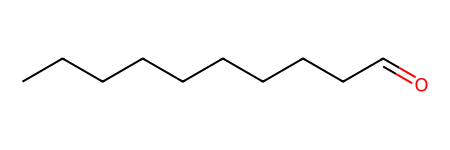

In [34]:
train_clean.X[46]